# Functional Encryption - Classification and information leakage

Our start point is the work on encrypted classification using Function Encryption of the paper [Reading in the Dark: Classifying Encrypted Digits with Functional Encryption](https://eprint.iacr.org/2018/206), and the associated [GitHub repository](https://github.com/edufoursans/reading-in-the-dark).

More specifically, the paper provides a new Functional Encryption scheme for quadratic multi-variate polynomials, which can under some hypothesis be seen as a single hidden layer neural network with a quadratic activation.
In the paper, the output corresponds to element per class, and it is made in clear. We analyse how this output can disclose information about the initial input or about charasteristics of this input.

To this aim, we have just built a dataset which is very similar to MNIST, used in the original paper but which is composed of 26 letter characters of 5 differents fonts. Our goal is two-fold:
 - Evaluate how the output in clear can be leverage with a public NN to make better prediction than a simple `argmax` function in the character recognition task.
 - Analyse to what extent the output in clear of the model trained for character recognition can reveal information about the font used, using an "adversarial" network.
 
We now have a quadratic network working, let's leverage its output with a public NN to make better predictions!

# 2 Quadratic model improvements


We will now use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [1]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from learn import main, train, test, show_results, show_confusion_matrix

In [3]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 60
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 300

## 2.1 Proof of interest on the family task
What we are primarily interested in is optimising the network with a public part on char recognition task. However, as we already have a high accuracy there is no massive improvement to expect. We will hence start by the family recognition task on which we perform less well.

### 2.1.1 Quadratic baseline
We recall the base quadratic model that we have seen previously.

In [4]:
class QuadNet(nn.Module):
    def __init__(self, output_size):
        super(QuadNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, output_size)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return F.log_softmax(x, dim=1)

Let's train it with the hyperparameters tuned, using the conclusions of Part 2.

In [5]:
results = {}
model=QuadNet(5)
results['QuadNet'], pred_labels = main(model=model, model_type='quad', args=Parser(), task='family', return_pred_label=True)

Training set 60000 items
Testing set  10000 items
Learning on family with quad 
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.824283
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.582572
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.420442
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.445881

Test set: Average loss: 1.3352, Accuracy: 4482/10000 (44.82%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.443651
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.394637
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.364703
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.344161

Test set: Average loss: 1.2055, Accuracy: 5256/10000 (52.56%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.365144
Train Epoch: 3 [19200/60000 (32%)]	Loss: 1.374833
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.191931
Train Epoch: 3 [57600/60000 (96%)]	Loss: 1.307714

Test set: Average loss: 1.1387, Accuracy: 5494/10000 (54.94%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.276365
Train Epoch: 4 [19200/60000 (32%)]	Loss: 1.470317
Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.39360

Train Epoch: 32 [19200/60000 (32%)]	Loss: 0.920491
Train Epoch: 32 [38400/60000 (64%)]	Loss: 1.023734
Train Epoch: 32 [57600/60000 (96%)]	Loss: 0.968738

Test set: Average loss: 0.8850, Accuracy: 6525/10000 (65.25%)

Train Epoch: 33 [0/60000 (0%)]	Loss: 0.976479
Train Epoch: 33 [19200/60000 (32%)]	Loss: 0.855570
Train Epoch: 33 [38400/60000 (64%)]	Loss: 0.898866
Train Epoch: 33 [57600/60000 (96%)]	Loss: 1.088844

Test set: Average loss: 0.8852, Accuracy: 6585/10000 (65.85%)

Train Epoch: 34 [0/60000 (0%)]	Loss: 0.764942
Train Epoch: 34 [19200/60000 (32%)]	Loss: 0.904522
Train Epoch: 34 [38400/60000 (64%)]	Loss: 1.129325
Train Epoch: 34 [57600/60000 (96%)]	Loss: 0.935605

Test set: Average loss: 0.8778, Accuracy: 6585/10000 (65.85%)

Train Epoch: 35 [0/60000 (0%)]	Loss: 0.905546
Train Epoch: 35 [19200/60000 (32%)]	Loss: 1.006094
Train Epoch: 35 [38400/60000 (64%)]	Loss: 1.051452
Train Epoch: 35 [57600/60000 (96%)]	Loss: 1.002033

Test set: Average loss: 0.8716, Accuracy: 6617/10000 (66.

For the sake of curiosity, let's print the confusion matrix for the base model

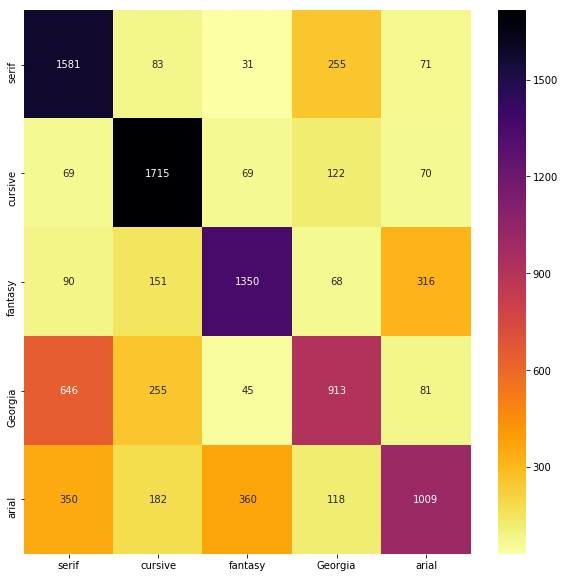

In [6]:
show_confusion_matrix(pred_labels, task='family')

### 2.1.2 Quadratic + Linear1
Here we try to add linear wider model on top of the input, which consists or 2 linear units and 2 relu activations.

In [7]:
class QuadLinear1Net(nn.Module):
    def __init__(self, output_size):
        super(QuadLinear1Net, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, output_size)
        
        # --- Linear
        self.lin1 = nn.Linear(output_size, 4*output_size)
        self.lin2 = nn.Linear(4*output_size, output_size)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        
        # --- Linear
        x = F.relu(x)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        
        return F.log_softmax(x, dim=1)

In [8]:
results[f'QuadNet + Linear1'] = main(model=QuadLinear1Net(5), model_type='quad', args=Parser(), task='family')


Training set 60000 items
Testing set  10000 items
Learning on family with quad 
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.762951
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.762710
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.716875
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.680540

Test set: Average loss: 1.5417, Accuracy: 3060/10000 (30.60%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.685228
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.646946
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.539577
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.489233

Test set: Average loss: 1.4016, Accuracy: 3892/10000 (38.92%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.474529
Train Epoch: 3 [19200/60000 (32%)]	Loss: 1.549471
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.467225
Train Epoch: 3 [57600/60000 (96%)]	Loss: 1.464823

Test set: Average loss: 1.3100, Accuracy: 4428/10000 (44.28%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.451353
Train Epoch: 4 [19200/60000 (32%)]	Loss: 1.712063
Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.48127

Train Epoch: 32 [19200/60000 (32%)]	Loss: 0.726940
Train Epoch: 32 [38400/60000 (64%)]	Loss: 0.905908
Train Epoch: 32 [57600/60000 (96%)]	Loss: 0.794089

Test set: Average loss: 0.7617, Accuracy: 6903/10000 (69.03%)

Train Epoch: 33 [0/60000 (0%)]	Loss: 0.857578
Train Epoch: 33 [19200/60000 (32%)]	Loss: 0.773236
Train Epoch: 33 [38400/60000 (64%)]	Loss: 0.657559
Train Epoch: 33 [57600/60000 (96%)]	Loss: 0.969237

Test set: Average loss: 0.7946, Accuracy: 6818/10000 (68.18%)

Train Epoch: 34 [0/60000 (0%)]	Loss: 0.827044
Train Epoch: 34 [19200/60000 (32%)]	Loss: 0.788995
Train Epoch: 34 [38400/60000 (64%)]	Loss: 0.913415
Train Epoch: 34 [57600/60000 (96%)]	Loss: 0.813637

Test set: Average loss: 0.7621, Accuracy: 6856/10000 (68.56%)

Train Epoch: 35 [0/60000 (0%)]	Loss: 0.822204
Train Epoch: 35 [19200/60000 (32%)]	Loss: 0.853968
Train Epoch: 35 [38400/60000 (64%)]	Loss: 0.873687
Train Epoch: 35 [57600/60000 (96%)]	Loss: 0.731566

Test set: Average loss: 0.7576, Accuracy: 6962/10000 (69.

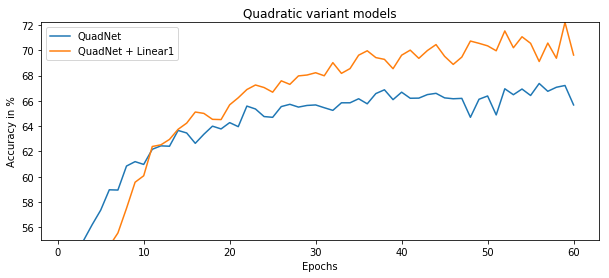

In [9]:
show_results(results, 'Quadratic variant models', ymin=55)

### 2.1.3 Quadratic + Linear2
Let's try to a wiser Linear model which performs quite well on MNIST too

In [10]:
class QuadLinear2Net(nn.Module):
    def __init__(self, output_size):
        super(QuadLinear2Net, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, output_size)
        
        # --- Junction
        self.jct = nn.Linear(output_size, 784)
        
        # --- Linear 2
        self.fc1 = nn.Linear(784, 548)
        self.bc1 = nn.BatchNorm1d(548)
        
        self.fc2 = nn.Linear(548, 252)
        self.bc2 = nn.BatchNorm1d(252)
        
        self.fc3 = nn.Linear(252, output_size)
        

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        
        # --- Junction
        x = self.jct(x)
        x = x.view((-1, 784))
        
        # --- Linear
        h = self.fc1(x)
        h = self.bc1(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.fc2(h)
        h = self.bc2(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.2, training=self.training)
        
        h = self.fc3(h)
        
        return F.log_softmax(x, dim=1)

In [11]:
results[f'QuadNet + Linear2'] = main(model=QuadLinear2Net(5), model_type='quad', args=Parser(), task='family')


Training set 60000 items
Testing set  10000 items
Learning on family with quad 
Train Epoch: 1 [0/60000 (0%)]	Loss: 6.895414
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.766610
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.562130
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.534756

Test set: Average loss: 1.4375, Accuracy: 3640/10000 (36.40%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.676715
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.604550
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.501226
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.538976

Test set: Average loss: 1.2916, Accuracy: 4642/10000 (46.42%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.383972
Train Epoch: 3 [19200/60000 (32%)]	Loss: 1.479716
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.532210
Train Epoch: 3 [57600/60000 (96%)]	Loss: 1.353020

Test set: Average loss: 1.2448, Accuracy: 4806/10000 (48.06%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.470068
Train Epoch: 4 [19200/60000 (32%)]	Loss: 1.339513
Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.29254

Train Epoch: 32 [19200/60000 (32%)]	Loss: 0.873099
Train Epoch: 32 [38400/60000 (64%)]	Loss: 0.820873
Train Epoch: 32 [57600/60000 (96%)]	Loss: 1.062580

Test set: Average loss: 0.9064, Accuracy: 6371/10000 (63.71%)

Train Epoch: 33 [0/60000 (0%)]	Loss: 0.982983
Train Epoch: 33 [19200/60000 (32%)]	Loss: 0.884282
Train Epoch: 33 [38400/60000 (64%)]	Loss: 1.043217
Train Epoch: 33 [57600/60000 (96%)]	Loss: 1.048657

Test set: Average loss: 0.8915, Accuracy: 6524/10000 (65.24%)

Train Epoch: 34 [0/60000 (0%)]	Loss: 0.973110
Train Epoch: 34 [19200/60000 (32%)]	Loss: 0.809673
Train Epoch: 34 [38400/60000 (64%)]	Loss: 1.156587
Train Epoch: 34 [57600/60000 (96%)]	Loss: 1.007146

Test set: Average loss: 0.9022, Accuracy: 6429/10000 (64.29%)

Train Epoch: 35 [0/60000 (0%)]	Loss: 0.863299
Train Epoch: 35 [19200/60000 (32%)]	Loss: 0.833623
Train Epoch: 35 [38400/60000 (64%)]	Loss: 0.860330
Train Epoch: 35 [57600/60000 (96%)]	Loss: 1.092739

Test set: Average loss: 0.9069, Accuracy: 6424/10000 (64.

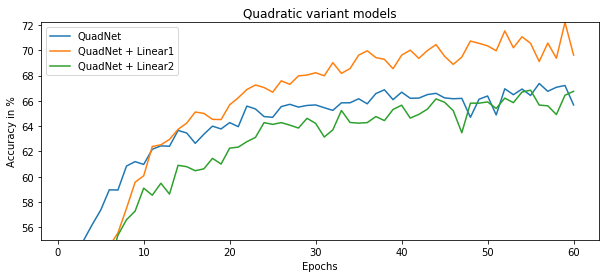

In [12]:
show_results(results, 'Quadratic variant models', ymin=55)

As this shows, choosing the right network is crucial to expect improvements.

### 2.1.4 Quadratic + Conv1
Here we try to add a CNN wider model on top of the input, which consists of the CNN block used previously and which is provided in the [official Pytorch tutorial on MNIST](https://github.com/pytorch/examples/blob/master/mnist/main.py).

In [13]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 40
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 300

In [14]:
class QuadConv1Net(nn.Module):
    def __init__(self, output_size):
        super(QuadConv1Net, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, output_size)
        
        # --- Junction
        self.jct = nn.Linear(output_size, 784)
        
        # --- CNN
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, output_size)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        
        # --- Junction
        x = self.jct(x)
        x = x.view(-1, 1, 28, 28)
        
        # --- CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [15]:
model = QuadConv1Net(5)
results['QuadNet + Conv1'], pred_labels = main(model=model, args=Parser(), model_type='quad', task='family', return_pred_label=True)


Training set 60000 items
Testing set  10000 items
Learning on family with quad 
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.757575
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.759021
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.752294
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.749179

Test set: Average loss: 1.6055, Accuracy: 2497/10000 (24.97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.744921
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.732295
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.696734
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.673413

Test set: Average loss: 1.5444, Accuracy: 3125/10000 (31.25%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.681847
Train Epoch: 3 [19200/60000 (32%)]	Loss: 1.627440
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.572493
Train Epoch: 3 [57600/60000 (96%)]	Loss: 1.527028

Test set: Average loss: 1.4217, Accuracy: 3665/10000 (36.65%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.475886
Train Epoch: 4 [19200/60000 (32%)]	Loss: 1.626309
Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.58082

Train Epoch: 32 [19200/60000 (32%)]	Loss: 0.685189
Train Epoch: 32 [38400/60000 (64%)]	Loss: 0.597074
Train Epoch: 32 [57600/60000 (96%)]	Loss: 0.564797

Test set: Average loss: 0.5662, Accuracy: 7768/10000 (77.68%)

Train Epoch: 33 [0/60000 (0%)]	Loss: 0.556941
Train Epoch: 33 [19200/60000 (32%)]	Loss: 0.762248
Train Epoch: 33 [38400/60000 (64%)]	Loss: 0.610023
Train Epoch: 33 [57600/60000 (96%)]	Loss: 0.486171

Test set: Average loss: 0.5807, Accuracy: 7718/10000 (77.18%)

Train Epoch: 34 [0/60000 (0%)]	Loss: 0.623941
Train Epoch: 34 [19200/60000 (32%)]	Loss: 0.743234
Train Epoch: 34 [38400/60000 (64%)]	Loss: 0.959957
Train Epoch: 34 [57600/60000 (96%)]	Loss: 0.463570

Test set: Average loss: 0.5848, Accuracy: 7659/10000 (76.59%)

Train Epoch: 35 [0/60000 (0%)]	Loss: 0.635036
Train Epoch: 35 [19200/60000 (32%)]	Loss: 0.633121
Train Epoch: 35 [38400/60000 (64%)]	Loss: 0.661261
Train Epoch: 35 [57600/60000 (96%)]	Loss: 0.575424

Test set: Average loss: 0.5705, Accuracy: 7764/10000 (77.

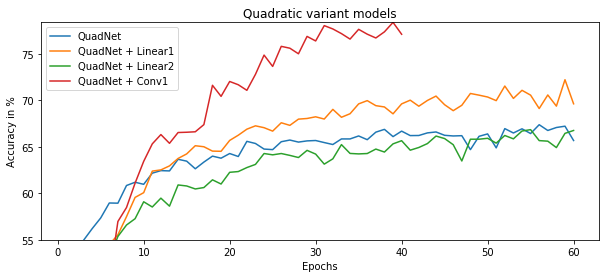

In [16]:
show_results(results, 'Quadratic variant models', ymin=55)

The CNN configuration really outperforms the linear ones, which we could have expected because the CNN alone was doing really good. What's interesting is that it managed to exploit the private quadratic model to leverage its 5 bits output and achieve a very good performance.

For the sake of curiosity, let's build the confusion matrix to understand if there is an obvious weakness on this very model on family/fonts recognition.

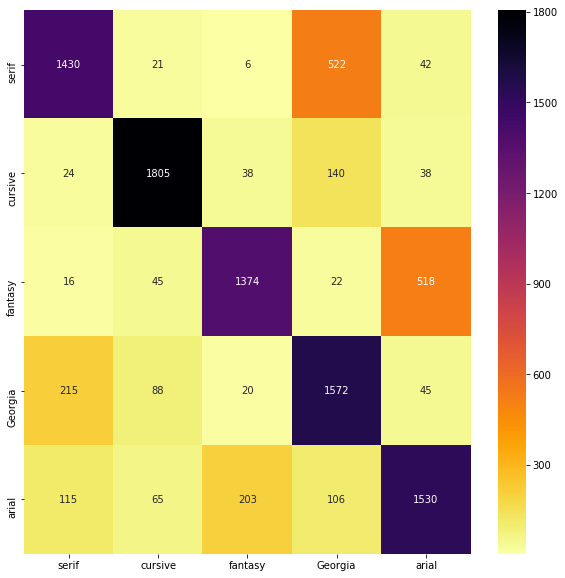

In [17]:
show_confusion_matrix(pred_labels, task='family')

This shows as a conclusion that we can expect some improvements on the global accuracy if we use a public network to leverage (and optimize) the output of the private quadratic network.

### Subsidiary question (TODO)
The CNN modifed the private model in depth. If we remove the CNN part, can we expect some interesting behaviour from the private part?

In [18]:
def private_forward(self, x):
    x = x.view(-1, 784)
    x = self.proj1(x)
    x = x * x
    x = self.diag1(x)
    return F.log_softmax(x, dim=1)

model.private_forward = private_forward